# Working With NWB Files

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

from allensdk.brain_observatory.ecephys import nwb  # for compat
import pynwb
from pynwb import NWBHDF5IO

import nems
from nems.recording import Recording
from nems.signal import PointProcess

import h5py

from matplotlib import pyplot as plt

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2019-12-10 155251.log


## Generate session and get metadata

In [2]:
data_dir = Path(r'data')
manifest_path = data_dir / 'manifest.json'

`manifest.json` is where the library keeps a record of previously downloaded files. If it doesn't exists in location you specify, it will be created
the first time you create the cache object. Otherwise, when you request data, the library will check the manifest to see if it's been downloaded.

In [3]:
# assert manifest_path.exists()

In [4]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()

[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[numexpr.utils INFO] NumExpr defaulting to 8 threads.
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache


## Download data from session

You can edit the download criteria to filter out the data. Downloading the data can take several minutes.

In [5]:
# 21 is just a random number, for this example notebook
session = cache.get_session_data(sessions.iloc[21].name,
                                 isi_violations_maximum=np.inf,
                                 amplitude_cutoff_maximum=np.inf,
                                 presence_ratio_minimum=-np.inf
                                )

[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache


This is the epochs table. It applies to all the units.

In [6]:
# this can be slow depending on the size of the data
presentation_table = session.stimulus_presentations
presentation_table.head()

,color,contrast,frame,orientation,phase,pos,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,,
0,null,null,null,null,null,null,null,null,24.752216,null,spontaneous,84.818986,null,null,null,60.066770,0
1,null,0.8,null,45,"[3644.93333333, 3644.93333333]","[-30.0, 40.0]","[20.0, 20.0]",0.08,84.818986,0,gabors,85.052505,4,0,10,0.233520,1
2,null,0.8,null,0,"[3644.93333333, 3644.93333333]","[-30.0, 40.0]","[20.0, 20.0]",0.08,85.052505,0,gabors,85.302704,4,20,40,0.250199,2
3,null,0.8,null,0,"[3644.93333333, 3644.93333333]","[-30.0, 40.0]","[20.0, 20.0]",0.08,85.302704,0,gabors,85.552904,4,-40,40,0.250199,3
4,null,0.8,null,90,"[3644.93333333, 3644.93333333]","[-30.0, 40.0]","[20.0, 20.0]",0.08,85.552904,0,gabors,85.803103,4,10,30,0.250199,4


Included is metadata about each unit, as a pandas dataframe.

In [7]:
session.units.head()

[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache


,waveform_duration,firing_rate,waveform_PT_ratio,d_prime,waveform_recovery_slope,waveform_velocity_below,presence_ratio,L_ratio,waveform_amplitude,max_drift,...,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,
951853174,0.219765,19.441146,0.199007,6.714259,-0.049973,0.206030,0.99,0.000089,84.471855,48.84,...,215.0,APN,7928,3129,7167,probeA,,29999.96621,1249.998592,True
951853190,0.137353,10.267881,0.734993,2.744475,-0.154760,-0.431682,0.99,0.137435,95.045925,50.17,...,215.0,APN,7908,3068,7169,probeA,,29999.96621,1249.998592,True
951853197,0.151089,10.161642,0.625356,3.389818,-0.102740,-0.343384,0.99,0.073114,73.191495,47.14,...,215.0,APN,7905,3060,7169,probeA,,29999.96621,1249.998592,True
951853216,0.563149,6.664585,0.645313,5.647242,-0.024678,0.286153,0.99,0.009056,45.769815,32.12,...,215.0,APN,7866,2948,7168,probeA,,29999.96621,1249.998592,True
951853225,0.576884,9.174408,0.558268,4.388771,-0.033880,0.073582,0.99,0.017206,57.620160,38.75,...,215.0,APN,7854,2913,7167,probeA,,29999.96621,1249.998592,True


Spike times are stored in a dictionary, with the unit IDs as keys and arrays for the spike times.

In [8]:
# this is a large dict, so let's just look at one key
session.spike_times[951853174]

[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache
[call_caching INFO] Reading data from cache


array([3.79479685e+00, 3.80853020e+00, 3.80933020e+00, ...,
       9.62280203e+03, 9.62339993e+03, 9.62352627e+03])

## Loading existing NWB files with session

If you've previously downloaded data, you can avoid the cache creation and just create a session from an NWB file.

In [9]:
nwb_filepath = Path(r'/auto/users/tomlinsa/code/allen/data/session_760345702/session_760345702.nwb')
assert nwb_filepath.exists()

In [10]:
session = EcephysSession.from_nwb_path(str(nwb_filepath), api_kwargs={
        "amplitude_cutoff_maximum": np.inf,
        "presence_ratio_minimum": -np.inf,
        "isi_violations_maximum": np.inf
    })

In [11]:
# session.stimulus_presentations

## or from NWB file (preffered)

This is the raw data. The session method of getting the data does it's own formatting of the dataframes.

In [12]:
nwb_filepath = Path(r'/auto/users/tomlinsa/code/allen/data/session_760345702/session_760345702.nwb')
assert nwb_filepath.exists()

In [13]:
io = NWBHDF5IO(str(nwb_filepath), 'r')
nwbfile = io.read()

In [14]:
nwbfile.lab_meta_data

{'metadata': 
 metadata <class 'allensdk.brain_observatory.ecephys.nwb.EcephysLabMetaData'>
 Fields:
   age_in_days: 103.0
   full_genotype: Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
   sex: M
   specimen_name: Pvalb-IRES-Cre;Ai32-407972
   stimulus_name: brain_observatory_1.1
   strain: C57BL/6J}

The rest of the attributes are still accessible.

In [15]:
# nwbfile.units
# nwbfile.epochs
# nwbfile.stimulus_presentations

## Load into NEMS

In [16]:
r = Recording.from_nwb(nwb_filepath, 'neuropixel')

[nems.recording INFO] Loading NWB file with format "neuropixel" from "/auto/users/tomlinsa/code/allen/data/session_760345702/session_760345702.nwb".
[nems.recording INFO] Successfully loaded nwb file.


All of the usual attributes are accessible.

In [17]:
r.epochs.head()

,start,end,name,stimulus_block,temporal_frequency,x_position,y_position,color,colorSpace,depth,...,tex,texRes,units,stimulus_index,orientation,spatial_frequency,frame,contrast,flipHoriz,flipVert
0,24.752216,84.818986,spontaneous,NaN,NaN,NaN,NaN,,,NaN,...,,NaN,,NaN,NaN,,NaN,NaN,NaN,NaN
1,84.818986,85.052505,gabors,0.0,4.0,0.0,10.0,"[1.0, 1.0, 1.0]",rgb,0.0,...,sin,256.0,deg,0.0,45.0,0.08,NaN,0.8,NaN,NaN
2,85.052505,85.302704,gabors,0.0,4.0,20.0,40.0,"[1.0, 1.0, 1.0]",rgb,0.0,...,sin,256.0,deg,0.0,0.0,0.08,NaN,0.8,NaN,NaN
3,85.302704,85.552904,gabors,0.0,4.0,-40.0,40.0,"[1.0, 1.0, 1.0]",rgb,0.0,...,sin,256.0,deg,0.0,0.0,0.08,NaN,0.8,NaN,NaN
4,85.552904,85.803103,gabors,0.0,4.0,10.0,30.0,"[1.0, 1.0, 1.0]",rgb,0.0,...,sin,256.0,deg,0.0,90.0,0.08,NaN,0.8,NaN,NaN


In [18]:
r.meta

{'specimen_name': 'Pvalb-IRES-Cre;Ai32-407972',
 'age_in_days': 103.0,
 'full_genotype': 'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'strain': 'C57BL/6J',
 'sex': 'M',
 'stimulus_name': 'brain_observatory_1.1',
 'uri': '/auto/users/tomlinsa/code/allen/data/session_760345702/session_760345702.nwb'}

All of the spike times are saved into a single `PointProcess` signal.

In [19]:
r.signals

{'session_760345702': <nems.signal.PointProcess at 0x7fd3ea723f98>}

In [20]:
signal = r.signals['session_760345702']
signal.nchans

1784

Each channel key is the unit ID from the units dataframe of the NWB file

In [21]:
# ex, unit 951843010
signal._data[951843010]

array([  10.2351168 ,   11.66955413,   11.69268753, ..., 9612.18553725,
       9612.20010396, 9620.83476135])

The `units` metadata is saved into the meta of the signal.

In [22]:
# ex, unit 951843010
signal.meta[951843010]

{'waveform_duration': 0.755443886097152,
 'firing_rate': 1.74113707219344,
 'PT_ratio': 0.00729943086142739,
 'd_prime': nan,
 'recovery_slope': -0.00895206089461061,
 'quality': 'noise',
 'velocity_below': 1.03015075376884,
 'presence_ratio': 0.99,
 'l_ratio': 0.0,
 'amplitude': 51.4938450000001,
 'max_drift': 23.6,
 'snr': 1.92770330724404,
 'nn_hit_rate': nan,
 'spread': 60.0,
 'nn_miss_rate': nan,
 'cumulative_drift': 615.49,
 'waveform_halfwidth': 0.357118927973199,
 'isolation_distance': nan,
 'isi_violations': 1.06689648479891,
 'silhouette_score': 0.0759991877886951,
 'local_index': 263,
 'amplitude_cutoff': 0.268061054461112,
 'repolarization_slope': 0.122863156143529,
 'cluster_id': 267,
 'velocity_above': 1.37353433835846,
 'peak_channel_id': 850096152}

## Get stimulus images

For example, frame 100 from `natural_scenes`, as in this random row:

In [23]:
r.epochs.loc[[51357], ['start', 'end', 'name', 'frame']]  # list loc to keep as df

,start,end,name,frame
51357,5910.169789,5910.420001,natural_scenes,100.0


In [24]:
im = cache.get_natural_scene_template(100)

[call_caching INFO] Reading data from cache


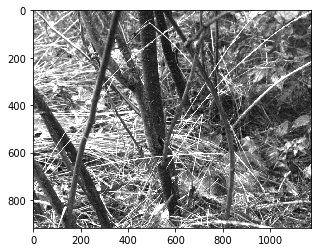

In [25]:
plt.imshow(im, cmap=plt.cm.gray)